In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(ms

In [2]:
#Set path to data
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_neurotransmitters.h5ad"
# path_rna = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_lipids.h5ad"


In [3]:
# Set task/dataset name and path to store
task_name  = "MSI_concat_neurotransmitters"
store_dir = "/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/"
# name of final data will be a combination of task_name and topN abundant metabs

In [4]:
sc.read_h5ad(path_msi)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata_msi_full = sc.read_h5ad(path_msi)
# adata_rna_full = sc.read_h5ad(path_rna)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Prepare MSI data

In [6]:
adata_msi_full

AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
adata_msi_full.var_names_make_unique()

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

In [8]:
adata_msi_full.var_names  

Index(['156.26059', '156.26195', '156.48344', '156.4838', '156.485',
       '157.54681', '158.41217', '160.02547', '170.45622', '170.45738',
       ...
       '1044.29885', '1044.3523', '1046.31366', '1046.32671', '1046.33977',
       '1046.36442', '1048.32025', '1048.3319', '1048.34354', '1048.38431'],
      dtype='object', length=1538)

In [9]:
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Quality control

In [10]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

<Axes: xlabel='total_counts', ylabel='Count'>

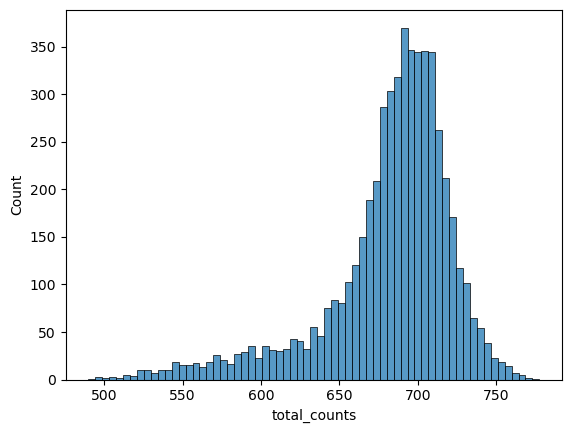

In [11]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites m/z ratios for each cell

<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

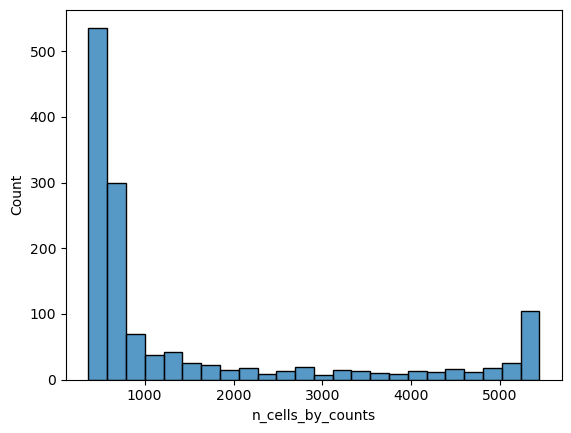

In [12]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums all the cells for each metabolite m/z ratio
# we notice that o

In [13]:
adata_msi.var.n_cells_by_counts.describe()

count    1361.000000
mean     1519.506980
std      1639.893486
min       367.000000
25%       510.000000
50%       632.000000
75%      1718.000000
max      5443.000000
Name: n_cells_by_counts, dtype: float64

### Let's identify most spatialy variable metabolites

In [14]:
adata_msi

AnnData object with n_obs × n_vars = 5443 × 1361
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

MoranI already present, but just for completeness let's go for the procedure from beginning



In [15]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


Do a sorting based first on index, then on Benjamini Hochberg FDR correction pvalue and select the top 30

In [16]:
adata_msi.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
427.13738,0.488514,0.000000,0.000053,0.000000
426.13386,0.487936,0.000000,0.000053,0.000000
426.1394,0.474630,0.000000,0.000053,0.000000
427.14125,0.467735,0.000000,0.000053,0.000000
428.14054,0.466312,0.000000,0.000053,0.000000
...,...,...,...,...
821.33307,-0.013087,0.037941,0.000053,0.122560
1046.32671,-0.013630,0.032172,0.000053,0.108194
1046.33977,-0.014331,0.025814,0.000053,0.089892
793.99352,-0.014405,0.025207,0.000053,0.088406


In [17]:
top_30_spat = adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_values(by=["I", "pval_norm_fdr_bh"], ascending=[False, True]).index[:30]


Mini correction for known matrix peaks, select matrix and mode


In [18]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

array([ 289.11568,  289.11778,  289.11933, ..., 1048.3319 , 1048.34354,
       1048.38431])

In [19]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))

# dhb_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_positive[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


In [20]:
found_peaks

set()

In [21]:
top_30_spat_filtered = [mz for mz in top_30_spat if mz not in found_peaks_str]
print(top_30_spat_filtered, len(top_30_spat_filtered))

['427.13738', '426.13386', '426.1394', '427.14125', '428.14054', '426.12809', '390.16864', '569.20536', '428.14952', '674.28833', '435.20692', '431.08294', '427.13472', '703.17781', '432.08618', '674.28592', '432.08346', '622.28469', '555.20345', '433.07846', '427.13255', '539.19172', '433.08094', '675.29202', '428.13762', '430.16497', '573.21671', '558.18881', '574.22262', '690.30231'] 30


In [22]:
# ['203.05299000000002',
#  '162.11293999999998',
#  '214.01164',
#  '280.092375',
#  '845.51016',
#  '251.9674',
#  '353.023935',
#  '251.96654999999998',
#  '617.9799350000001',
#  '297.070615']

In [23]:
top_5_spat_metabolites = top_30_spat_filtered[:5]
top_10_spat_metabolites = top_30_spat_filtered[:10]
top_20_spat_metabolites = top_30_spat_filtered[:20]
adata_msi_top5_spat = adata_msi[:, adata_msi.var_names.isin(top_5_spat_metabolites)].copy()
adata_msi_top10_spat = adata_msi[:, adata_msi.var_names.isin(top_10_spat_metabolites)].copy()
adata_msi_top20_spat = adata_msi[:, adata_msi.var_names.isin(top_20_spat_metabolites)].copy()



/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
task_name

'MSI_concat_neurotransmitters'

In [25]:
adata_msi_top5_spat.write(os.path.join(store_dir, f"{task_name}_top5spatvar.h5ad"))
adata_msi_top10_spat.write(os.path.join(store_dir, f"{task_name}_top10spatvar.h5ad"))
adata_msi_top20_spat.write(os.path.join(store_dir, f"{task_name}_top20spatvar.h5ad"))

In [26]:
adata_msi_top5_spat

AnnData object with n_obs × n_vars = 5443 × 5
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

To use in big pipeline split in train and test

In [27]:
# change_according to first part
ds_task_name = "neuro"

In [28]:
# adata_msi_top5_spat_train = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "train"].copy()
# adata_msi_top5_spat_test = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "test"].copy()

# for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
#     adata_msi_top5_spat_train.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_train.h5ad"))
#     adata_msi_top5_spat_test.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_test.h5ad"))


In [31]:
adata_msi_top10_spat_train = adata_msi_top10_spat[adata_msi_top10_spat.obs["half_split"]=="train"].copy()
adata_msi_top10_spat_test = adata_msi_top10_spat[adata_msi_top10_spat.obs["half_split"]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    adata_msi_top10_spat_train.write(os.path.join(f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{ds_task_name}_top10_spatvar",feat_sel,"msi_dataset_train.h5ad"))
    adata_msi_top10_spat_test.write(os.path.join(f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{ds_task_name}_top10_spatvar",feat_sel,"msi_dataset_test.h5ad"))
    print(os.path.join(f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{ds_task_name}_top10_spatvar",feat_sel,"msi_dataset_train.h5ad"))


/lustre/groups/ml01/workspace/eirini.giannakoulia/neuro_top10_spatvar/hvg/msi_dataset_train.h5ad
/lustre/groups/ml01/workspace/eirini.giannakoulia/neuro_top10_spatvar/hvg_svd/msi_dataset_train.h5ad
/lustre/groups/ml01/workspace/eirini.giannakoulia/neuro_top10_spatvar/hvg_svd_graph/msi_dataset_train.h5ad
/lustre/groups/ml01/workspace/eirini.giannakoulia/neuro_top10_spatvar/svd/msi_dataset_train.h5ad
/lustre/groups/ml01/workspace/eirini.giannakoulia/neuro_top10_spatvar/svd_graph/msi_dataset_train.h5ad


In [32]:
adata_msi_top20_spat

AnnData object with n_obs × n_vars = 5443 × 20
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [33]:
adata_msi_top20_spat_train = adata_msi_top20_spat[adata_msi_top20_spat.obs["half_split"]=="train"].copy()
adata_msi_top20_spat_test = adata_msi_top20_spat[adata_msi_top20_spat.obs["half_split"]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    adata_msi_top20_spat_train.write(os.path.join(f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{ds_task_name}_top20_spatvar",feat_sel,"msi_dataset_train.h5ad"))
    adata_msi_top20_spat_test.write(os.path.join(f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{ds_task_name}_top20_spatvar",feat_sel,"msi_dataset_test.h5ad"))
